# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = 'C:/Users/jarit/Downloads/asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [4]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    n_samples = len(x)
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)
    
    split_idx = int(n_samples * pct)
    
    x_val_split = x[indices[:split_idx]]
    y_val_split = y[indices[:split_idx]]
    x_test_split = x[indices[split_idx:]]
    y_test_split = y[indices[split_idx:]]
    
    return x_val_split, y_val_split, x_test_split, y_test_split

In [6]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

Validation data shape: (3586, 784)
Test data shape: (3586, 784)


In [7]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

print("Classes:", alphabet)

24
Classes: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


### Normalise

In [8]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)
print("Data normalized to [0, 1] range")

Data normalized to [0, 1] range


### Graficar muestras

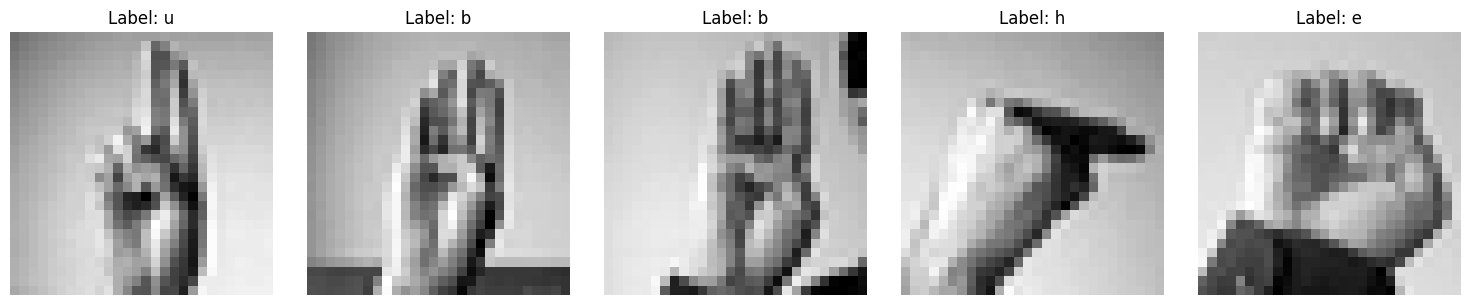

In [9]:
def plot_asl_samples(x_data, y_data, alphabet, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img = x_data[idx].reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {alphabet[y_data[idx]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_asl_samples(x_train, y_train, alphabet)

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [10]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

In [11]:
class np_tensor(np.ndarray): pass

In [12]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    
    

### Clase ReLU

In [13]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [14]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))    
    def evaluate(self, x, y):
        """
        Evalúa el modelo en un conjunto de datos
        """
        correct = 0
        total = len(x)
        
        for i in range(total):
            xi = x[i].reshape(-1, 1)
            yi = y[i]
            
            pred = self.predict(xi)
            
            if pred == yi:
                correct += 1
        
        accuracy = correct / total
        return accuracy

### Cost Function

In [15]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Loop de entrenamiento

In [58]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train  )):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [59]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

### Create your model and train it

In [18]:
model = Sequential_layers([Linear(784, 256), ReLU(), Linear(256, 128), ReLU(), Linear(128, 24)])
mb_size = 2048
learning_rate = 1e-4
epochs = 10

In [46]:

# Para mejor precisión en MNIST:
model = Sequential_layers([
    Linear(784, 512),
    ReLU(),
    Linear(512, 256),
    ReLU(),
    Linear(256, 128),
    ReLU(),
    Linear(128, 24)
])

mb_size = 64              # Batch más pequeño
learning_rate = 1e-3      # LR inicial más alto
epochs = 10              # Con early stopping

# Usar optimizador Adam
# Añadir weight decay (L2 regularization)
# Usar cross-entropy como loss function

In [54]:
train(model, epochs, mb_size, learning_rate)

costo: 0.0004642831779375632, accuracy: 0.8011712214166202
costo: 0.000299155149911559, accuracy: 0.7994980479643057
costo: 0.00034017048361432626, accuracy: 0.800334634690463
costo: 0.00025311390624595606, accuracy: 0.8006134969325154
costo: 0.0004415739068518742, accuracy: 0.7992191857222533
costo: 0.0002277209416260562, accuracy: 0.7994980479643057
costo: 0.00024235755860497064, accuracy: 0.8000557724484105
costo: 0.00033108035612352404, accuracy: 0.8000557724484105
costo: 0.00017476928477491187, accuracy: 0.7992191857222533
costo: 0.0001742109810806342, accuracy: 0.7997769102063581


### Test your model on Random data from your test set

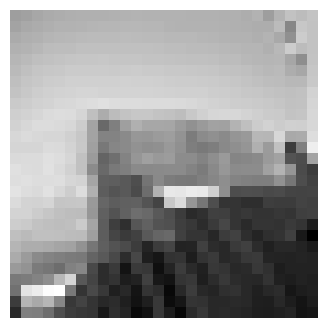

El valor predicho es: h
El valor real es: h


In [56]:
def plot_number(img_array):
    """
    Función para visualizar imagen ASL
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(img_array.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

# Probar con datos aleatorios
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'El valor predicho es: {alphabet[pred]}')
print(f'El valor real es: {alphabet[y_test[idx]]}')


Prueba con múltiples ejemplos:


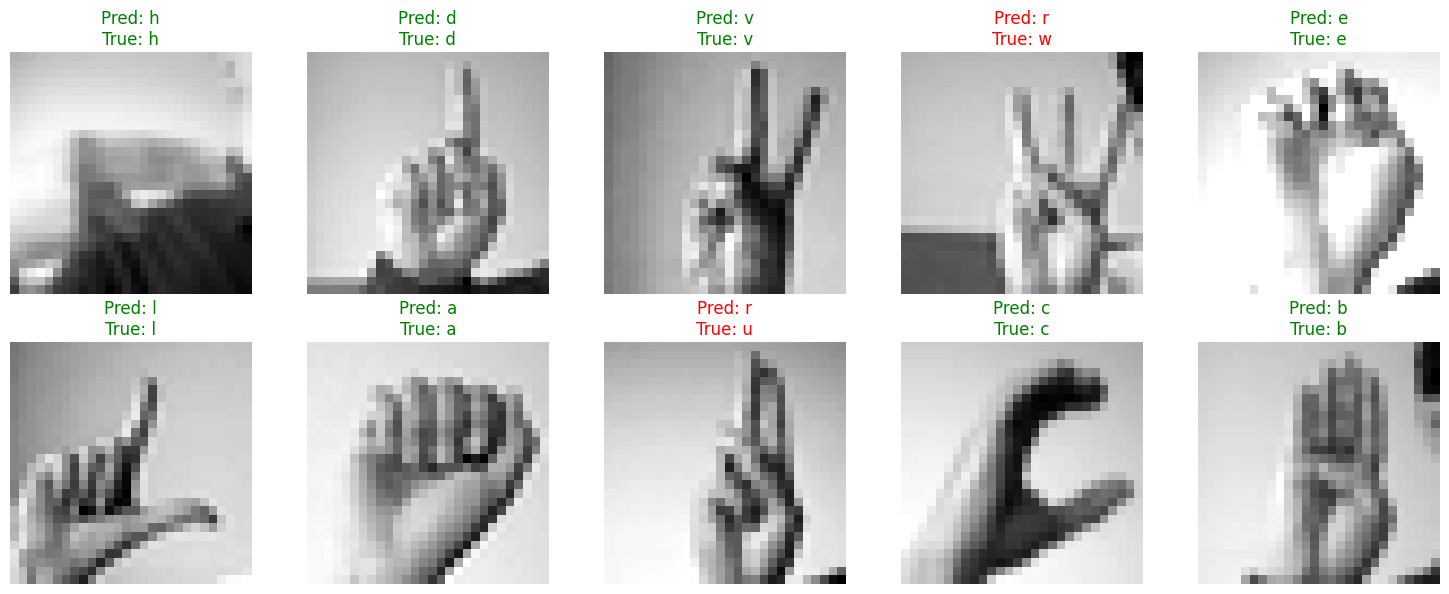


Precisión final en Test Set: 0.7817 (78.17%)


In [57]:
# Prueba adicional con múltiples ejemplos
print("\nPrueba con múltiples ejemplos:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

indices = np.random.choice(len(y_test), 10, replace=False)

for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    
    img = x_test[idx].reshape(28, 28)
    axes[row, col].imshow(img, cmap='gray')
    
    pred = model.predict(x_test[idx].reshape(-1, 1))
    true_label = y_test[idx]
    
    color = 'green' if pred == true_label else 'red'
    axes[row, col].set_title(f"Pred: {alphabet[pred]}\nTrue: {alphabet[true_label]}", color=color)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Calcular precisión en test set
test_accuracy = model.evaluate(x_test, y_test)
print(f"\nPrecisión final en Test Set: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
